In [1]:
import numpy as np 
import pandas as pd

# visualizations
import matplotlib.pyplot as plt
#import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
dataTA = pd.read_csv('dataTA2.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'

In [3]:
dataTA.tail(12)

,KasusDBD,Tavg,RHavg,ss,nordbd,norsuhu,norkelembapan,norss
Tahun,,,,,,,,
2021-01-01,177.0,23.32,80.10,3.11,0.151163,0.463871,0.824566,0.234050
2021-02-01,152.0,23.48,80.18,3.90,0.118863,0.495000,0.828410,0.322619
2021-03-01,167.0,23.65,80.29,4.72,0.138243,0.529032,0.833662,0.413262
2021-04-01,194.0,23.72,77.37,5.86,0.173127,0.544000,0.696272,0.540370
2021-05-01,311.0,24.09,79.26,5.74,0.324289,0.617419,0.785153,0.526523
2021-06-01,273.0,23.49,80.33,5.06,0.275194,0.497333,0.835683,0.451481
2021-07-01,242.0,23.14,72.94,7.24,0.235142,0.428387,0.488040,0.692832
2021-08-01,366.0,23.48,73.23,6.28,0.395349,0.496774,0.501683,0.587097
2021-09-01,347.0,23.84,74.70,5.22,0.370801,0.568667,0.570959,0.468889


In [4]:
# drop the null values if any
dataTA.dropna(inplace=True)
dataTA.shape

(120, 8)

PLOT DATA

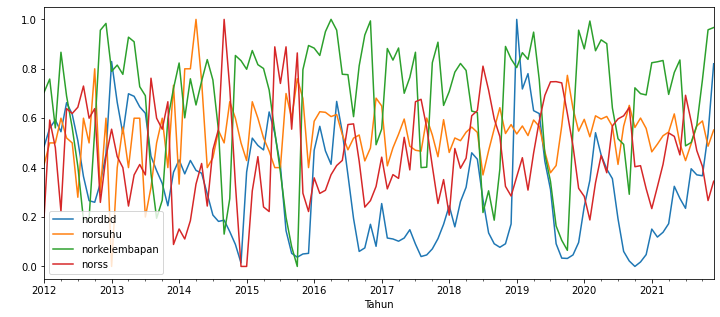

In [5]:
ylabel= ' '
xlabel= 'Tahun'

ax = dataTA['nordbd'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
dataTA['norsuhu'].plot(legend=True);
dataTA['norkelembapan'].plot(legend=True);
dataTA['norss'].plot(legend=True);


TEST FOR STATIONARITY

In [6]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [7]:
for name, column in dataTA[['nordbd','norkelembapan','norsuhu','norss']].iteritems():
    Augmented_Dickey_Fuller_Test_func(dataTA[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: nordbd
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: norkelembapan
Test Statistic                  -2.621547
p-value                          0.088625
No Lags Used                    13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: norsuhu
Test Statistic                  -3.631566
p-value                          0.005185
N

TRAIN TEST SPLIT

In [8]:
dataTA=dataTA[['nordbd','norkelembapan','norsuhu','norss']]
dataTA

,nordbd,norkelembapan,norsuhu,norss
Tahun,,,,
2012-01-01,0.485788,0.704811,0.412000,0.200000
2012-02-01,0.559432,0.758442,0.500000,0.592593
2012-03-01,0.593023,0.560802,0.500000,0.481481
2012-04-01,0.545220,0.867011,0.600000,0.222222
2012-05-01,0.662791,0.689653,0.520000,0.638889
...,...,...,...,...
2021-08-01,0.395349,0.501683,0.496774,0.587097
2021-09-01,0.370801,0.570959,0.568667,0.468889
2021-10-01,0.366925,0.754836,0.589032,0.405018


In [25]:
dataTA.corr()

,nordbd,norkelembapan,norsuhu,norss
nordbd,1.000000,0.315890,-0.162375,-0.116923
norkelembapan,0.315890,1.000000,-0.085796,-0.725546
norsuhu,-0.162375,-0.085796,1.000000,-0.076632
norss,-0.116923,-0.725546,-0.076632,1.000000


In [9]:
pq = []
for name, column in dataTA[['nordbd','norkelembapan','norsuhu','norss']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(dataTA[name],start_p=1, start_q=1,d=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : nordbd
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-118.481, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-122.000, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-120.462, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-120.437, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-123.953, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.430 seconds
optimal order for:nordbd is: (0, 1, 0) 


Searching order of p and q for : norkelembapan
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32.232, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.203, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-32.188, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-32.655, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-35.189, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total 

In [10]:
n = 12 # The last 12 months will be the test data. At least 1 year would be a good choice
train = dataTA[0:-n]
test = dataTA[-n:]

In [11]:
dataTA_transformed = train.diff().diff() # 2nd order difference
dataTA_transformed = dataTA_transformed.dropna() # remove the NaNs introduced due to differencing
dataTA_transformed.head()

,nordbd,norkelembapan,norsuhu,norss
Tahun,,,,
2012-03-01,-0.040052,-0.251271,-0.088,-0.503704
2012-04-01,-0.081395,0.503849,0.100,-0.148148
2012-05-01,0.165375,-0.483568,-0.180,0.675926
2012-06-01,-0.164083,0.049266,0.060,-0.436508
2012-07-01,-0.060724,-0.028802,-0.200,0.045238


In [26]:
for name, column in dataTA_transformed[['nordbd','norkelembapan','norsuhu','norss']].iteritems():
    Augmented_Dickey_Fuller_Test_func(dataTA_transformed[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: nordbd
Test Statistic                -6.668532e+00
p-value                        4.650910e-09
No Lags Used                   1.200000e+01
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: norkelembapan
Test Statistic                -6.488299e+00
p-value                        1.244873e-08
No Lags Used                   1.300000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: norsuhu
Test Statistic                 -4.436317
p-value                     

In [27]:
dataTA_transformed.corr()

,nordbd,norkelembapan,norsuhu,norss
nordbd,1.000000,-0.042405,-0.155855,-0.006475
norkelembapan,-0.042405,1.000000,-0.206538,-0.388568
norsuhu,-0.155855,-0.206538,1.000000,0.156028
norss,-0.006475,-0.388568,0.156028,1.000000


In [13]:
dataTA_transformed

,nordbd,norkelembapan,norsuhu,norss
Tahun,,,,
2012-03-01,-0.040052,-0.251271,-0.088000,-0.503704
2012-04-01,-0.081395,0.503849,0.100000,-0.148148
2012-05-01,0.165375,-0.483568,-0.180000,0.675926
2012-06-01,-0.164083,0.049266,0.060000,-0.436508
2012-07-01,-0.060724,-0.028802,-0.200000,0.045238
...,...,...,...,...
2020-08-01,0.031008,0.101868,0.309269,-0.016069
2020-09-01,0.093023,-0.179320,-0.070581,0.020915
2020-10-01,0.016796,0.633016,-0.173677,-0.273013


In [14]:
len(dataTA_transformed)

106

In [15]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [16]:
cointegration_test(dataTA_transformed[['nordbd','norkelembapan','norsuhu','norss']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
nordbd >  229.41    > 40.1749   =>   True
norkelembapan >  138.27    > 24.2761   =>   True
norsuhu >  79.36     > 12.3212   =>   True
norss  >  32.61     > 4.1296    =>   True


In [17]:
pq = []
for name, column in dataTA_transformed[['nordbd','norkelembapan','norsuhu','norss']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(dataTA_transformed[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : nordbd
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-38.032, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-65.073, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-69.736, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-73.739, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-71.773, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-71.741, Time=0.14 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.958 seconds
optimal order for:nordbd is: (3, 0, 0) 


Searching order of p and q for : norkelembapan
Performing stepwise search to minimize aic
 ARIMA(1,0,1)

In [18]:
pq

[(3, 0, 0), (4, 0, 0), (7, 0, 0), (4, 0, 0)]

In [19]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res


In [20]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE KasusDBD','RMSE TAVG','RMSE RHAVG','RMSE SS'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[2] == 0 and i[0] == 0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(dataTA_transformed[['nordbd','norkelembapan','norsuhu','norss']], order=(i[0],i[2]))
        results = model.fit( maxiter=1000, disp=False)
        result = results.forecast(steps = 12)
        inv_res = inverse_diff(dataTA[['nordbd','norkelembapan','norsuhu','norss']] , result)
        DBDrmse = np.sqrt(metrics.mean_squared_error(test['nordbd'], inv_res.nordbd_1st_inv_diff))
        Suhurmse = np.sqrt(metrics.mean_squared_error(test['norsuhu'], inv_res.norsuhu_1st_inv_diff))
        Kelembapanrmse = np.sqrt(metrics.mean_squared_error(test['norkelembapan'], inv_res.norkelembapan_1st_inv_diff))
        Ssrmse = np.sqrt(metrics.mean_squared_error(test['norss'], inv_res.norss_1st_inv_diff))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE KasusDBD':DBDrmse,'RMSE TAVG':Suhurmse,'RMSE RHAVG':Kelembapanrmse,'RMSE SS':Ssrmse }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (3, 0, 0)
 Running for (4, 0, 0)
 Running for (7, 0, 0)


c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Running for (4, 0, 0)
 Total time taken to complete grid search in seconds: 364.9524096


In [21]:
result

,nordbd,norkelembapan,norsuhu,norss
2021-01-01,-0.013841,-0.009510,0.075020,0.063133
2021-02-01,-0.046952,-0.009529,-0.006005,0.118084
2021-03-01,-0.049398,0.120862,-0.020885,-0.270468
2021-04-01,0.071752,-0.073053,-0.014273,0.152447
2021-05-01,0.016712,-0.001810,0.007975,-0.033100
2021-06-01,-0.026530,0.003076,0.019705,0.022195
2021-07-01,-0.011195,-0.002860,-0.004498,0.004813
2021-08-01,0.005128,0.004130,-0.028863,-0.042688
2021-09-01,0.003978,0.009264,0.028045,0.034500
2021-10-01,-0.003550,-0.014222,-0.014203,-0.019024


In [22]:
inv_res

,nordbd,norkelembapan,norsuhu,norss,nordbd_1st_inv_diff,norkelembapan_1st_inv_diff,norsuhu_1st_inv_diff,norss_1st_inv_diff
2021-01-01,-0.013841,-0.009510,0.075020,0.063133,0.806573,0.957549,0.627278,0.407936
2021-02-01,-0.046952,-0.009529,-0.006005,0.118084,0.759621,0.948021,0.621273,0.526020
2021-03-01,-0.049398,0.120862,-0.020885,-0.270468,0.710223,1.068882,0.600387,0.255552
2021-04-01,0.071752,-0.073053,-0.014273,0.152447,0.781975,0.995829,0.586114,0.407999
2021-05-01,0.016712,-0.001810,0.007975,-0.033100,0.798687,0.994019,0.594089,0.374900
2021-06-01,-0.026530,0.003076,0.019705,0.022195,0.772157,0.997096,0.613793,0.397095
2021-07-01,-0.011195,-0.002860,-0.004498,0.004813,0.760962,0.994236,0.609296,0.401908
2021-08-01,0.005128,0.004130,-0.028863,-0.042688,0.766090,0.998365,0.580433,0.359220
2021-09-01,0.003978,0.009264,0.028045,0.034500,0.770069,1.007629,0.608478,0.393720
2021-10-01,-0.003550,-0.014222,-0.014203,-0.019024,0.766519,0.993407,0.594275,0.374696


In [23]:
df_results_moni.sort_values(by = ['RMSE KasusDBD','RMSE TAVG','RMSE RHAVG','RMSE SS'] )

,p,q,RMSE KasusDBD,RMSE TAVG,RMSE RHAVG,RMSE SS
2,7.0,0.0,0.458281,0.107597,0.239629,0.166867
1,4.0,0.0,0.482921,0.100481,0.288629,0.157908
3,4.0,0.0,0.482921,0.100481,0.288629,0.157908
0,3.0,0.0,0.487865,0.086765,0.309613,0.158592


In [24]:
dataTA_transformed[['KasusDBD','Tavg','RHavg','ss']].corr()

KeyError: "None of [Index(['KasusDBD', 'Tavg', 'RHavg', 'ss'], dtype='object')] are in the [columns]"

In [ ]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(dataTA_transformed[[ 'KasusDBD','Tavg','RHavg','ss' ]], order=(7,0)).fit( disp=False)
print(model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    Statespace Model Results                                   
Dep. Variable:     ['KasusDBD', 'Tavg', 'RHavg', 'ss']   No. Observations:                  106
Model:                                          VAR(7)   Log Likelihood               -1185.840
                                           + intercept   AIC                           2623.680
Date:                                 Tue, 02 Aug 2022   BIC                           2959.273
Time:                                         09:02:33   HQIC                          2759.698
Sample:                                     03-01-2012                                         
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
Ljung-Box (L1) (Q):     0.94, 0.07, 0.12, 0.00   Jarque-Bera (JB):   363.67, 0.41, 13.70, 11.57
Prob(Q):                0.33, 0.80, 0.73

In [ ]:
dataTA.tail(12)

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2021-01-01,177.0,23.32,80.10,3.11
2021-02-01,152.0,23.48,80.18,3.90
2021-03-01,167.0,23.65,80.29,4.72
2021-04-01,194.0,23.72,77.37,5.86
2021-05-01,311.0,24.09,79.26,5.74
2021-06-01,273.0,23.49,80.33,5.06
2021-07-01,242.0,23.14,72.94,7.24
2021-08-01,366.0,23.48,73.23,6.28
2021-09-01,347.0,23.84,74.70,5.22


In [ ]:
df_forecast = model.forecast(12)
df_forecast

,KasusDBD,Tavg,RHavg,ss
2021-01-01,-11.114073,0.197319,-2.109308,1.321077
2021-02-01,-32.459239,0.177404,0.758832,0.838008
2021-03-01,-60.607834,-0.226103,1.377458,-2.091304
2021-04-01,10.571713,0.386593,-1.945049,1.590236
2021-05-01,47.907632,-0.853136,0.740825,-1.759475
2021-06-01,-75.498643,0.821660,1.840632,1.479509
2021-07-01,57.334380,-0.438927,-2.067041,-0.910040
2021-08-01,-0.067352,0.308035,1.291035,0.112041
2021-09-01,23.400183,0.008566,-0.274859,0.191702
2021-10-01,-5.822712,-0.200302,1.131431,-0.410288


In [ ]:
res = inverse_diff(dataTA[['KasusDBD','Tavg','RHavg','ss']],df_forecast)
res

,KasusDBD,Tavg,RHavg,ss,KasusDBD_1st_inv_diff,Tavg_1st_inv_diff,RHavg_1st_inv_diff,ss_1st_inv_diff
2021-01-01,-11.114073,0.197319,-2.109308,1.321077,683.885927,23.957319,81.020692,5.421077
2021-02-01,-32.459239,0.177404,0.758832,0.838008,651.426688,24.134723,81.779524,6.259085
2021-03-01,-60.607834,-0.226103,1.377458,-2.091304,590.818854,23.908620,83.156982,4.167782
2021-04-01,10.571713,0.386593,-1.945049,1.590236,601.390567,24.295213,81.211933,5.758018
2021-05-01,47.907632,-0.853136,0.740825,-1.759475,649.298199,23.442077,81.952759,3.998543
2021-06-01,-75.498643,0.821660,1.840632,1.479509,573.799556,24.263738,83.793391,5.478052
2021-07-01,57.334380,-0.438927,-2.067041,-0.910040,631.133936,23.824810,81.726350,4.568012
2021-08-01,-0.067352,0.308035,1.291035,0.112041,631.066584,24.132845,83.017385,4.680053
2021-09-01,23.400183,0.008566,-0.274859,0.191702,654.466767,24.141411,82.742526,4.871756
2021-10-01,-5.822712,-0.200302,1.131431,-0.410288,648.644055,23.941110,83.873957,4.461468


In [ ]:
train.tail(12)

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2020-01-01,248.0,23.98,81.29,3.55
2020-02-01,330.0,23.62,83.69,2.69
2020-03-01,479.0,24.05,81.13,4.05
2020-04-01,409.0,23.98,82.07,5.04
2020-05-01,365.0,24.04,81.74,4.41
2020-06-01,335.0,23.84,76.20,6.12
2020-07-01,209.0,23.06,73.55,6.37
2020-08-01,107.0,23.84,73.06,6.49
2020-09-01,77.0,24.26,68.76,6.79


In [ ]:
test

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2021-01-01,177.0,23.32,80.10,3.11
2021-02-01,152.0,23.48,80.18,3.90
2021-03-01,167.0,23.65,80.29,4.72
2021-04-01,194.0,23.72,77.37,5.86
2021-05-01,311.0,24.09,79.26,5.74
2021-06-01,273.0,23.49,80.33,5.06
2021-07-01,242.0,23.14,72.94,7.24
2021-08-01,366.0,23.48,73.23,6.28
2021-09-01,347.0,23.84,74.70,5.22


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
for i in ['KasusDBD','Tavg','RHavg','ss']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , inv_res[str(i)+'_1st_inv_diff'])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 140267.9172029112
MAE is : 350.68258854777287
RMSE is : 374.5235869780583
MAPE is : 1.5432835479081317

Evaluation metric for Tavg
Evaluation metric results:-
MSE is : 0.2502552801321936
MAE is : 0.4200926919196837
RMSE is : 0.5002552149974987
MAPE is : 0.017914369447915652

Evaluation metric for RHavg
Evaluation metric results:-
MSE is : 37.79882688719463
MAE is : 5.160155560717431
RMSE is : 6.148075055429515
MAPE is : 0.06755673511821421

Evaluation metric for ss
Evaluation metric results:-
MSE is : 2.0216007873835564
MAE is : 1.242243360041168
RMSE is : 1.4218300838650013
MAPE is : 0.2575911794044747



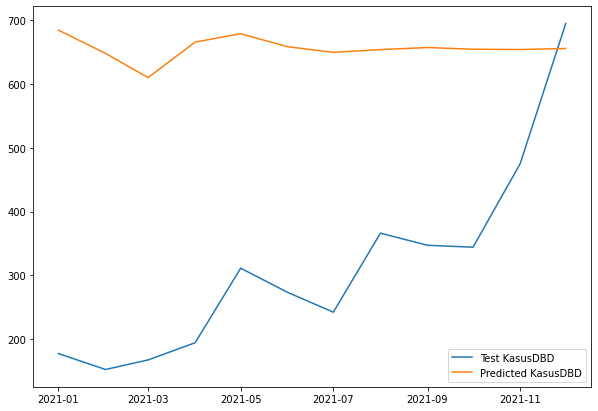

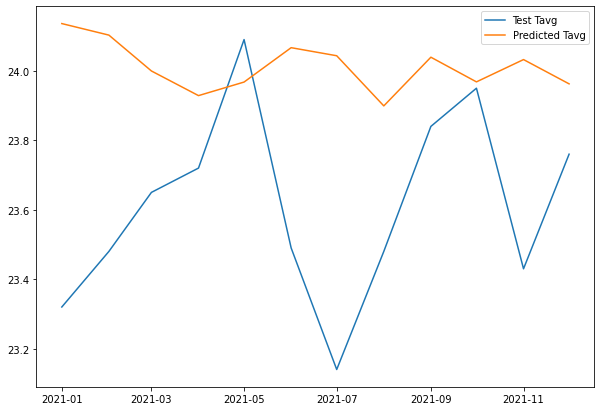

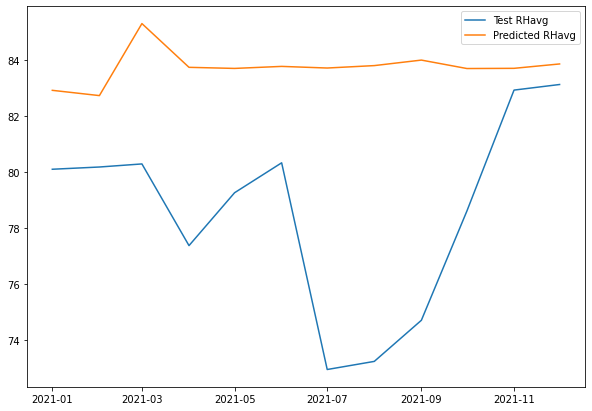

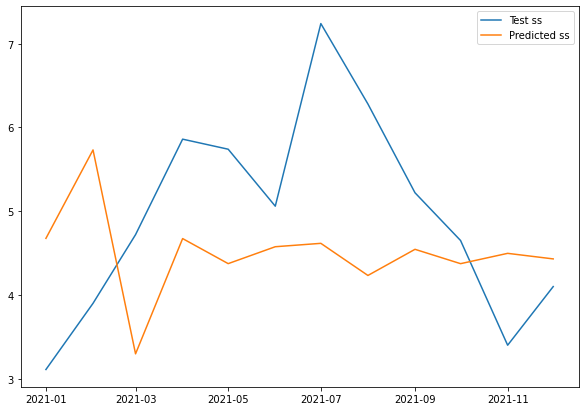

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['KasusDBD','Tavg','RHavg','ss' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    #plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    #plt.plot(dataTA[str(i)], label='KasusDBD '+str(i))
    plt.plot(inv_res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()